In [264]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


In [489]:
class CPSAnalyzer:
    schools_of_interest = ["SKINNER", "SKINNER NORTH", "PRESCOTT", 'BRONZEVILLE CLASSICAL',
                          "HEALY", "LINCOLN", "PRITZKER", "BELL", "MAYER", "MCDADE"]
    def __init__(self):
        filename = "./iar-parcc_2015to2023_schoollevel.xlsx"
        self.dfenglish = pd.read_excel(filename, sheet_name=1, header=[0, 1])
        self.dfmath = pd.read_excel(filename, sheet_name=2, header=[0, 1])
        self.dfenglish = self.dfenglish.iloc[:, :12]
        self.dfmath = self.dfmath.iloc[:, :12]
        self.dfenglish.columns = self.dfenglish.columns.droplevel()
        self.dfmath.columns = self.dfmath.columns.droplevel()

    def rank_schools(self):
        mathdf = self.dfmath.loc[self.dfmath['Year']==2023, :]
        self.ranked_math = mathdf.groupby("School Name")["% Met or Exceeded"].mean().sort_values(ascending = False).index.values
        self.ranked_math_exceed = mathdf.groupby("School Name")["% Exceeded"].mean().sort_values(ascending = False).index.values
        engdf = self.dfenglish.loc[self.dfenglish['Year']==2023, :]
        self.ranked_english = engdf.groupby("School Name")["% Met or Exceeded"].mean().sort_values(ascending = False).index.values
        self.ranked_english_exceed = engdf.groupby("School Name")["% Exceeded"].mean().sort_values(ascending = False).index.values
        return self.ranked_math, self.ranked_english
        
    def heatmap(self, school, subject="math", only_exceed=1, threshold=0):
        if only_exceed:
            valuename = "% Exceeded"
        else:
            valuename = "% Met or Exceeded"
            
        if subject == "math":
            test_of_interest = ["Mathematics Grade " + str(i) for i in range(3,9)]
            df = self.dfmath.loc[(self.dfmath['School Name'] == school) & (self.dfmath['Test Name'].isin(test_of_interest)), :]
        else:
            test_of_interest = ["ELA/Literacy Grade " + str(i) for i in range(3,9)]
            df = self.dfenglish.loc[(self.dfenglish['School Name'] == school) & (self.dfenglish['Test Name'].isin(test_of_interest)), :]
        
        if df.empty:
            print("empty data")
            return False

        nstudent = df['# Students Tested'].mean()
        dfp = df.pivot(columns='Year', index='Test Name', values=valuename)
        avg2023 = dfp.iloc[:, -1].mean()
        if avg2023 < threshold:
            return False
        dfp.index = [int(s[-1]) for s in dfp.index]
        dfp.index.name = 'Grade'
        dfp.sort_index(ascending=False, inplace=True)
        dfp.columns = dfp.columns.astype(str)
        try:
            dfp.loc[:, "2020"] = np.nan
            for i in range(3,7):
                dfp.loc[i+1, "2020"] = 0.5 * (dfp.loc[i, "2019"] + dfp.loc[i+2, "2021"])
        except:
            pass
        
        dfp.sort_index(axis=1, inplace=True)
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.set_title(f"{school} {subject} avg: {int(avg2023)} N: {int(nstudent)}")
        sns.heatmap(dfp, cbar=None, cmap=sns.light_palette('green', as_cmap=True), vmin=0, vmax=100, annot=dfp,
                   square=False,ax=ax, annot_kws={'color':'black', 'size':14}, fmt='.0f')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_ylabel("grade", rotation=0, labelpad=10)
        ax.set_xlabel("year")

        row_mean = dfp.mean(axis=1)
        col_mean = dfp.mean(axis=0)
        row_mean = row_mean.fillna(-1)
        col_mean = col_mean.fillna(-1)
        
        ax_right = ax.twinx()
        ax_right.set_ylim(ax.get_ylim())
        new_labels = [str(int(i)) for i in row_mean]
        ax_right.set_yticks(ax.get_yticks())
        ax_right.set_yticklabels(new_labels)
        ax_right.set_ylabel("row mean", rotation=0, labelpad=10)

        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        new_labels = [str(int(i)) for i in col_mean]
        ax_top.set_xticks(ax.get_xticks())
        ax_top.set_xticklabels(new_labels)
        ax_top.set_xlabel("column mean")
        return fig, ax, dfp
        
        



In [490]:
cps = CPSAnalyzer()

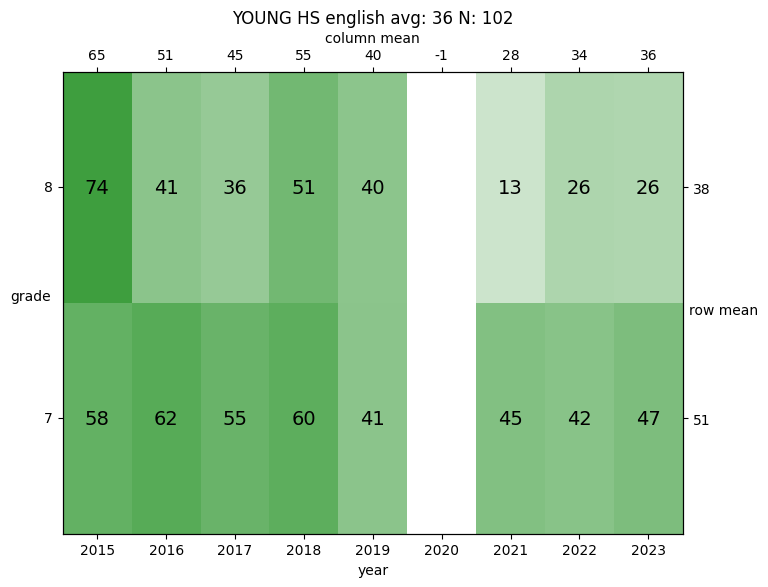

In [491]:
fig, ax, dfp = cps.heatmap("YOUNG HS", "english", only_exceed=1)

In [492]:
_ = cps.rank_schools()

In [493]:
nplots = 50
with PdfPages('eng_exceed.pdf') as pdf:
    for s in cps.ranked_english_exceed[:nplots]:
        if cps.heatmap(s, "english", only_exceed=1):
            pdf.savefig()  
            plt.close()

In [494]:
nplots = 50
with PdfPages('eng_met_or_exceed.pdf') as pdf:
    for s in cps.ranked_english[:nplots]:
        if cps.heatmap(s, "english", only_exceed=0):
            pdf.savefig()  
            plt.close()

In [495]:
nplots = 50
with PdfPages('math_exceed.pdf') as pdf:
    for s in cps.ranked_math_exceed[:nplots]:
        if cps.heatmap(s, "math", only_exceed=1):
            pdf.savefig()  
            plt.close()

In [496]:
nplots = 50
with PdfPages('math_met_or_exceed.pdf') as pdf:
    for s in cps.ranked_math[:nplots]:
        if cps.heatmap(s, "math", only_exceed=0):
            pdf.savefig()  
            plt.close()